In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
import re
import os
import copy
import pickle
import gzip
import math
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
date = datetime.datetime.now().strftime("%Y-%m-%d")
#from colorspacious import cspace_converter

In [3]:
def pickle_load(file,prefix):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        out=pickle.load(f)
    print([f"{prefix}_{i}"  for i in out[-1]])
    return out

#load metadata
def process_df(csv,meta2):
    df=pd.read_csv(csv,index_col=0)#.rename(columns=df.iloc[0]).drop(df.index[0])
    df=df.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SN54-TREU96']) #remove the known contaminated samples and Tbeq
    #clean up metadata
    meta2='/home/jovyan/Minicircle_gRNA_families/In_files/updated_metadata_isolates 2022-01-09.csv'
    metadf2=pd.read_csv(meta2,index_col=0,encoding='cp1252') #not utf8 encoding
    metadf2=metadf2.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SitaBip1','SN54-TREU96','ABBA_b'])
    metadf2['taxon']=metadf2['taxon'].fillna('T. brucei').replace('T.b.','T. brucei')
    metadf2.rename(columns={'Year of isolation ': 'Year of isolation'}, inplace=True)
    metadf2['continent']=metadf2['continent'].fillna('na').replace('Southern Africa\xa0','Southern Africa')
    metadf2['country']=metadf2['country'].fillna('na')
    metadf2['Year of isolation']=metadf2['Year of isolation'].fillna('na')
    for s in ['MHOM-CI-78-DALOA72-cloneA','MHOM-CI-79-DALOA74','MHOM-CI-91-SIQUE1623','MHOM-ZR-71-C126','MSUS-CI-82-TSW125-KP1-cloneB']:
        metadf2.loc[s,'taxon']='T.b. gambiense type I'
    for s in ['MSUS-CI-78-TSW168']:
        metadf2.loc[s,'taxon']='T.b. gambiense type II'
    for s in ['MSUS-CI-78-TSW178','MSUS-CI-78-TSW38-021','MSUS-CI-78-TSW382-bis']:
        metadf2.loc[s,'taxon']='T.b. brucei'
    #Zambia is assigned to EA and SA --> assign all Zambia to SA
    for s in metadf2[metadf2.apply(lambda x:x['country']=='Zambia' and x['continent']=='East Africa', axis=1)].index:
        metadf2.loc[s,'continent']='Southern Africa'
    #ignore Tbeq Tbev data for now
    metadf2=metadf2.loc[metadf2.index.intersection(df.index)]
    #combine
    combined=pd.concat([df,metadf2], axis=1) #append won't change the order of columns (no auto sorting)
    renames=rename_strain(combined)
    combined['renamed']=renames
    combined=combined.set_index('renamed')
    return(metadf2,combined)
#rename the strains
def rename_strain(df):
    new=[]
    taxon_dict={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII',
                              'T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr',
                             'T.b.':'Tb','T. brucei':'Tb'}
    for i,j in zip(df.index,df['taxon']):
        if j in taxon_dict:
            new.append(f'{taxon_dict[j]}_{i}')
        else:
            new.append(f'Tb_{i}')
    return(new)
#

In [4]:
#get minicircle class composition of strains and meta data
#csv='/home/jovyan/Minicircle_Population/Tb_normalized2maxi30_v3_mini_copy.csv' #Tb_mO_5750 to Tb_mO_6398 are SitaBip contigs, hence the df is shorter (5685) than total minicircle count 6398
csv='/home/jovyan/Minicircle_gRNA_families/In_files/Tb_copy_number_norm2_maxi30.20240209.csv'
#updated metadata, turns out is very much the same
meta2='/home/jovyan/Minicircle_gRNA_families/In_files/updated_metadata_isolates 2022-01-09.csv'
pickle='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_20240308.pickle'
#5 known Tbg1 strains in Tb are relabelled
metadf2,combined=process_df(csv,meta2)
metadf2.loc['AnTat-25-1S','taxon']='T. brucei'
metadf2.loc['Etat-1-2R','taxon']='T. brucei'

In [5]:
len(metadf2[metadf2['taxon']=='T.b. rhodesiense'])

17

In [6]:
meta_0405='/home/jovyan/Minicircle_gRNA_families/In_files/blast_summary.csv'
meta_0405=pd.read_csv(meta_0405,index_col=0,encoding='cp1252')

In [7]:
meta_0405.loc[['LOKO', 'LOKO-BIIT', 'LOKO-BIIT-P2', 'P26F']]

,species,BoTat1 (X60228.1) perc,BoTat1 (X60228.1) length,BoTat1 (X60228.1) coverage,LiTat1.3_1 (AJ304413.1) perc,LiTat1.3_1 (AJ304413.1) length,LiTat1.3_1 (AJ304413.1) coverage,LiTat1.3_2 (KJ499460.1) perc,LiTat1.3_2 (KJ499460.1) length,LiTat1.3_2 (KJ499460.1) coverage,LiTat1.5_1 (EU257624.1) perc,LiTat1.5_1 (EU257624.1) length,LiTat1.5_1 (EU257624.1) coverage,LiTat1.5_2 (HQ662603.1) perc,LiTat1.5_2 (HQ662603.1) length,LiTat1.5_2 (HQ662603.1) coverage,SRAnorth (AJ345057.1) perc,SRAnorth (AJ345057.1) length,SRAnorth (AJ345057.1) coverage,SRAsouth (AJ345058.1) perc,SRAsouth (AJ345058.1) length,SRAsouth (AJ345058.1) coverage,TgsGP_1 (AJ277951.1) perc,TgsGP_1 (AJ277951.1) length,TgsGP_1 (AJ277951.1) coverage,TgsGP_2 (FN555988.1) perc,TgsGP_2 (FN555988.1) length,TgsGP_2 (FN555988.1) coverage,VSG117 (S62479.1) perc,VSG117 (S62479.1) length,VSG117 (S62479.1) coverage,RoTat1.2 (AF317914.1) perc,RoTat1.2 (AF317914.1) length,RoTat1.2 (AF317914.1) coverage,SRA_Fre (Z37159.2) perc,SRA_Fre (Z37159.2) length,SRA_Fre (Z37159.2) coverage,TgsGP_Fre (FN555993.1) perc,TgsGP_Fre (FN555993.1) length,TgsGP_Fre (FN555993.1) coverage
strain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LOKO,T.b. gambiense type I,no hit,no hit,17.72,99.668,1507,103.71,100,1430,115.85,99.934,1518,23.42,97.882,1511,72.74,no hit,no hit,2.02,no hit,no hit,6.83,no hit,no hit,6.65,no hit,no hit,0.69,99.794,972,85.42,no hit,no hit,5.19,no hit,no hit,no_coverage_file,no hit,no hit,no_coverage_file
LOKO-BIIT,T.b. gambiense type I,no hit,no hit,23.04,99.668,1507,152.18,100,1430,159.55,99.934,1518,35.06,97.882,1511,115.64,no hit,no hit,2.33,no hit,no hit,10.48,no hit,no hit,10.63,no hit,no hit,1.06,99.794,971,141.95,no hit,no hit,10.83,no hit,no hit,no_coverage_file,no hit,no hit,no_coverage_file
LOKO-BIIT-P2,T.b. gambiense type I,no hit,no hit,21.6,99.668,1507,134.37,100,1430,126.41,99.934,1518,27.93,97.882,1511,96,no hit,no hit,2.82,no hit,no hit,9.33,no hit,no hit,8.87,no hit,no hit,1.23,99.794,971,114.76,no hit,no hit,8.46,no hit,no hit,no_coverage_file,no hit,no hit,no_coverage_file
P26F,T.b. gambiense type I,no hit,no hit,19.99,no hit,no hit,23.96,no hit,no hit,2.69,99.934,1518,24.72,97.882,1511,44.96,no hit,no hit,1.37,no hit,no hit,3.6,no hit,no hit,21.67,no hit,no hit,1.24,99.794,972,118.75,no hit,no hit,2.70,no hit,no hit,no_coverage_file,no hit,no hit,no_coverage_file


In [8]:
def make_base_line_coverage(meta_0405,metadf2,taxon,markers):
    df=meta_0405.loc[metadf2[metadf2['taxon']==taxon].index]
    fig, axs = plt.subplots(nrows=len(markers), ncols=2, figsize=(5*2, 5*len(markers)), sharey=False)
    for i,marker in enumerate(markers):
        coverage=[float(i) for i in df[df[f'{marker} perc']!= 'no hit'][f'{marker} coverage']]
        print(marker,min(coverage))
        length=[float(i) for i in df[f'{marker} length'] if i != 'no hit']
        length=[float(i) for i in df[df[f'{marker} perc']!= 'no hit'][f'{marker} length']]
        #coverage
        ax=axs[i,0]
        ax.hist(coverage,bins=range(0,round(max(coverage)),5))
        ax.set_ylabel('count')
        ax.set_xlabel('depth')
        ax.set_title(marker)
        #length
        ax=axs[i,1]
        ax.hist(length)
        ax.set_ylabel('count')
        ax.set_xlabel('length')
        ax.set_title(marker)
    plt.show()


In [9]:
#examine T. b. rhodesiense
df=meta_0405.loc[metadf2[metadf2['taxon']=='T.b. rhodesiense'].index]
marker='SRAsouth (AJ345058.1)'

markers=['LiTat1.3_1 (AJ304413.1)','LiTat1.3_2 (KJ499460.1)', 'LiTat1.5_1 (EU257624.1)',
                         'LiTat1.5_2 (HQ662603.1)','TgsGP_1 (AJ277951.1)','TgsGP_2 (FN555988.1)','TgsGP_Fre (FN555993.1)', 
                         'VSG117 (S62479.1)']
df[df[f'{marker} perc']!= 'no hit'][[f'{marker} perc' for marker in markers]]
df[df[f'{marker} perc']== 'no hit'][f'{marker} coverage']

Series([], Name: SRAsouth (AJ345058.1) coverage, dtype: object)

In [10]:
#examine T. b. gambiense type II
df=meta_0405.loc[metadf2[metadf2['taxon']=='T.b. gambiense type II'].index]
tbr_markers=['SRAsouth (AJ345058.1)','SRAnorth (AJ345057.1)']
tbg_markers=['TgsGP_1 (AJ277951.1)','TgsGP_2 (FN555988.1)','TgsGP_Fre (FN555993.1)']
tbg_sup=['LiTat1.3_1 (AJ304413.1)','LiTat1.3_2 (KJ499460.1)', 'LiTat1.5_1 (EU257624.1)','LiTat1.5_2 (HQ662603.1)','VSG117 (S62479.1)']
#print(df[[f'{marker} perc' for marker in tbg_markers+tbr_markers]])
#none specific TbgI markers
for marker in tbg_sup:
    d=df[df[f'{marker} perc']!='no hit'][f'{marker} coverage']
    print(d)
#Tbb with no hits on any genetic markers
no_hits=0
for i in df.index:
    hits=df.loc[i][[f'{marker} perc' for marker in tbr_markers+tbg_markers+tbg_sup]]
    hits=[0 if hit=='no hit' else 1 for hit in hits]
    #print(sum(hits))
    if sum(hits)==0:
        no_hits+=1
print(f"{no_hits} TbgII isolates has no hits on any genetic markers")
#metadf2[metadf2['taxon']=='T.b. gambiense type II']['host']

MSUS-CI-82-TSW65-KP1-exbiit    66.94
Muraz3                         73.78
Name: LiTat1.3_1 (AJ304413.1) coverage, dtype: object
MSUS-CI-82-TSW65-KP1-exbiit    49.7
Muraz3                         66.3
Name: LiTat1.3_2 (KJ499460.1) coverage, dtype: object
ABBA                       18.19
LIGO                       21.17
MSUS-CI-78-TSW-157         18.71
MSUS-NG-62-B8-18-cloneB    11.63
Muraz3                      6.19
Name: LiTat1.5_1 (EU257624.1) coverage, dtype: object
ABBA                       79.33
LIGO                       82.89
MSUS-CI-78-TSW-157         76.53
MSUS-NG-62-B8-18-cloneB    35.05
Muraz3                     28.42
Name: LiTat1.5_2 (HQ662603.1) coverage, dtype: object
MSUS-CI-78-TSW168    82.87
Name: VSG117 (S62479.1) coverage, dtype: object
5 TbgII isolates has no hits on any genetic markers


In [11]:
#examine T. b. brucei
df=meta_0405.loc[metadf2[metadf2['taxon']=='T.b. brucei'].index]
tbr_markers=['SRAsouth (AJ345058.1)','SRAnorth (AJ345057.1)']
tbg_markers=['TgsGP_1 (AJ277951.1)','TgsGP_2 (FN555988.1)','TgsGP_Fre (FN555993.1)']
tbg_sup=['LiTat1.3_1 (AJ304413.1)','LiTat1.3_2 (KJ499460.1)', 'LiTat1.5_1 (EU257624.1)','LiTat1.5_2 (HQ662603.1)','VSG117 (S62479.1)']
df[[f'{marker} perc' for marker in tbg_markers]]
df[[f'{marker} coverage' for marker in tbr_markers]]
#none specific TbgI markers
for marker in tbg_sup:
    d=df[df[f'{marker} perc']!='no hit'][f'{marker} coverage']
    print(d)
#Tbb with no hits on any genetic markers
no_hits=0
for i in df.index:
    hits=df.loc[i][[f'{marker} perc' for marker in tbr_markers+tbg_markers+tbg_sup]]
    hits=[0 if hit=='no hit' else 1 for hit in hits]
    #print(sum(hits))
    if sum(hits)==0:
        no_hits+=1
print(f"{no_hits} Tbb isolates has no hits on any genetic markers")

AGAL-CI-78-TCH312-bis    137.65
MCAP-CI-91-BALEA-2       129.69
MSUS-CI-85-PTAG-130       66.82
P8F                       38.52
Name: LiTat1.3_1 (AJ304413.1) coverage, dtype: object
AGAL-CI-78-TCH312-bis    102.66
MCAP-CI-91-BALEA-2        72.77
MSUS-CI-85-PTAG-130       35.88
P8F                       27.42
Name: LiTat1.3_2 (KJ499460.1) coverage, dtype: object
AnTat-17-1    23.6
Name: LiTat1.5_1 (EU257624.1) coverage, dtype: object
AnTat-17-1    57.12
Name: LiTat1.5_2 (HQ662603.1) coverage, dtype: object
AnTat-1-1                 31.79
AnTat-1-1E                42.07
AnTat-34-1-P10           114.96
J10                       55.31
Lister-427-AT1-KO         25.31
LIZZARD                   70.36
MCAP-CI-91-BALEA-2           56
MSUS-CI-78-TSW382-bis     48.84
MSUS-CI-85-PTAG-130       61.42
Name: VSG117 (S62479.1) coverage, dtype: object
13 Tbb isolates has no hits on any genetic markers


In [12]:
df=meta_0405.loc[metadf2[metadf2['taxon']=='T.b. gambiense type I'].index]
marker='TgsGP_2 (FN555988.1)'
df[df[f'{marker} perc']== 'no hit'][f'{marker} perc']

LOKO            no hit
LOKO-BIIT       no hit
LOKO-BIIT-P2    no hit
P26F            no hit
Name: TgsGP_2 (FN555988.1) perc, dtype: object

SRAnorth (AJ345057.1) 12.26
SRAsouth (AJ345058.1) 9.75


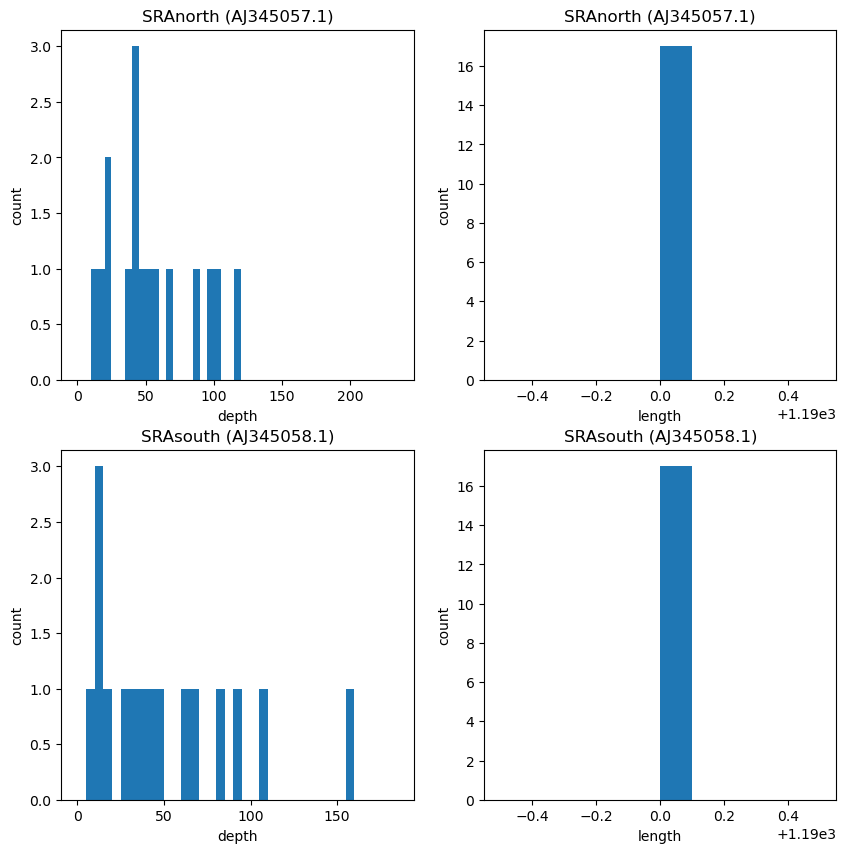

In [13]:
make_base_line_coverage(meta_0405,metadf2,'T.b. rhodesiense',
                        ['SRAnorth (AJ345057.1)','SRAsouth (AJ345058.1)']) #'TgsGP_Fre (FN555993.1)'

LiTat1.3_1 (AJ304413.1) 32.87
LiTat1.3_2 (KJ499460.1) 29.6
LiTat1.5_1 (EU257624.1) 10.69
LiTat1.5_2 (HQ662603.1) 26.09
TgsGP_1 (AJ277951.1) 12.57
TgsGP_2 (FN555988.1) 25.14
VSG117 (S62479.1) 56.35


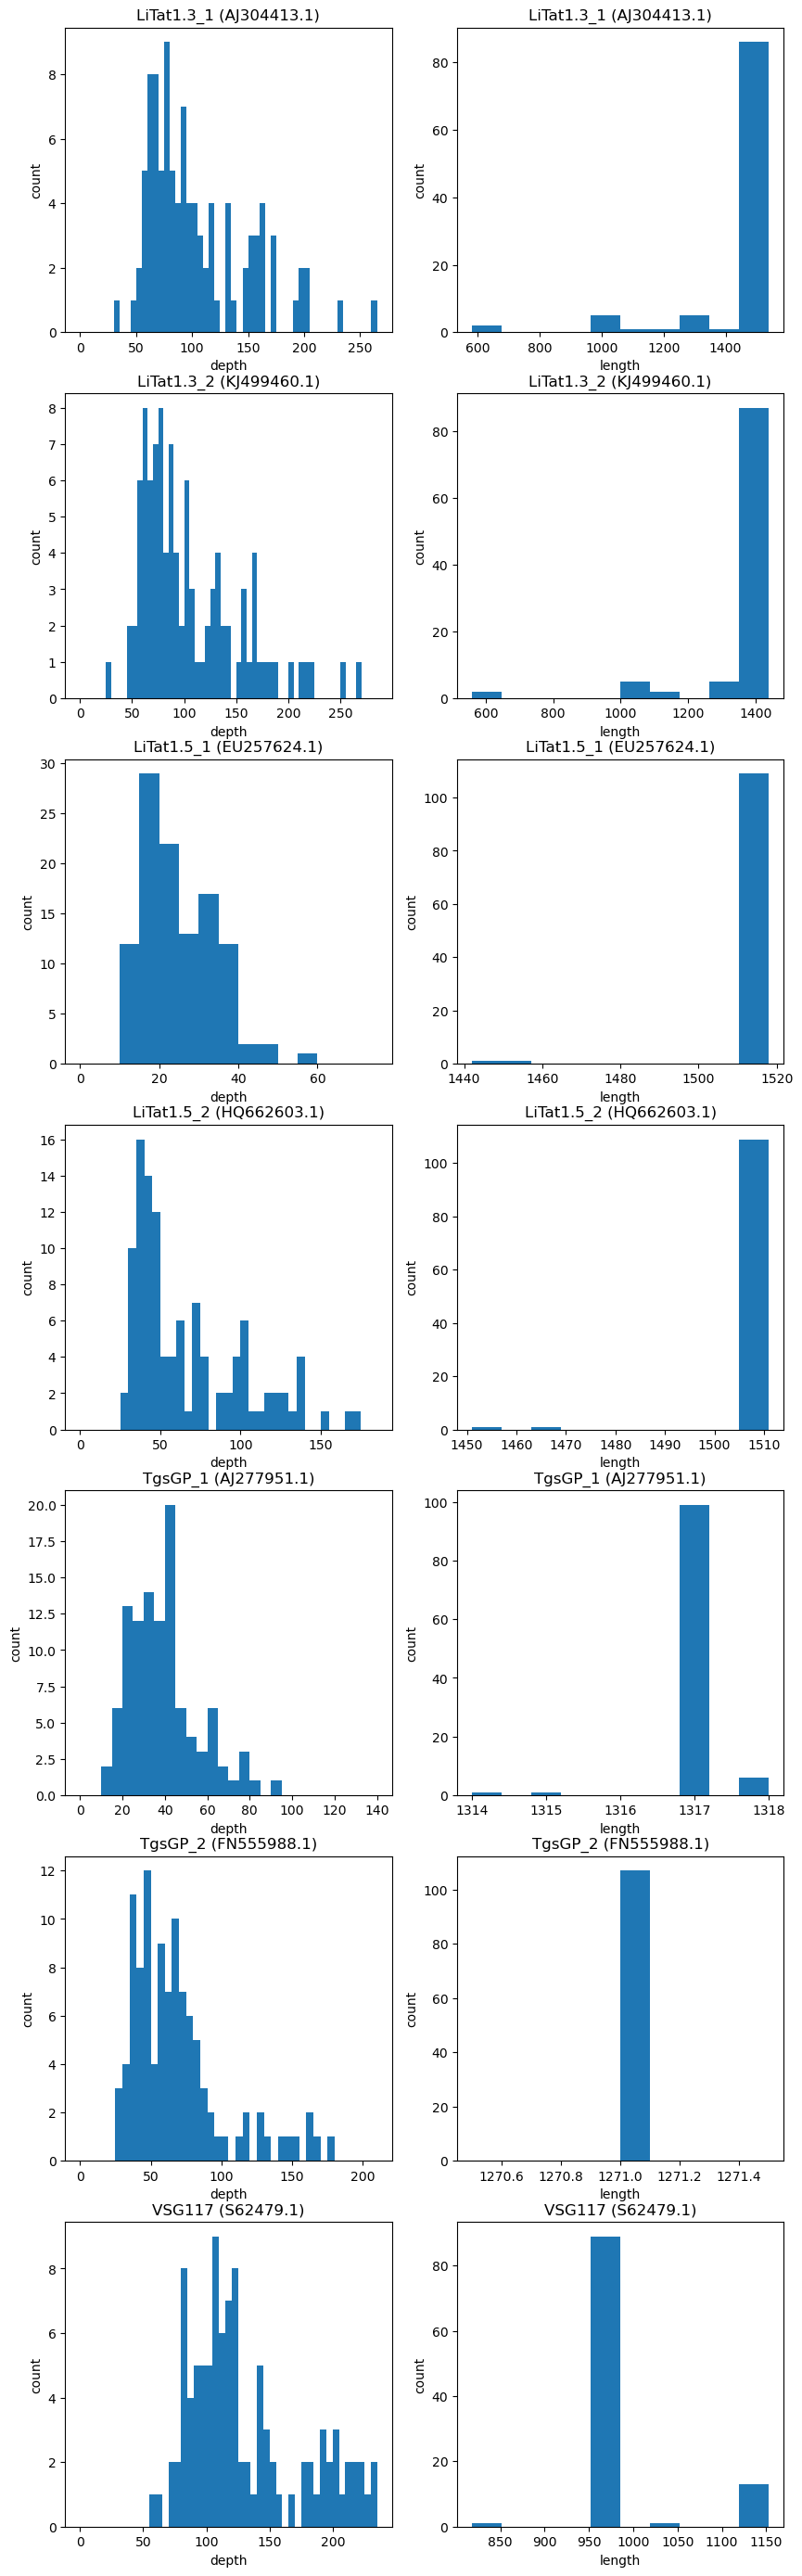

In [14]:
make_base_line_coverage(meta_0405,metadf2,'T.b. gambiense type I',
                        ['LiTat1.3_1 (AJ304413.1)','LiTat1.3_2 (KJ499460.1)', 'LiTat1.5_1 (EU257624.1)',
                         'LiTat1.5_2 (HQ662603.1)','TgsGP_1 (AJ277951.1)','TgsGP_2 (FN555988.1)', 
                         'VSG117 (S62479.1)']) #'TgsGP_Fre (FN555993.1)'

In [15]:
def output_probable_species1(meta_0405,metadf2,tax_dct={}):
    #dct=meta_0405.loc[metadf2[metadf2['taxon']=='T. brucei'].index].to_dict('index')
    dct=meta_0405.loc[metadf2.index].to_dict('index') #reannotate all the strains
    tax_dct={strain: 'T.b. brucei' for strain in dct}
    for strain in dct:
        found=[]
        for k,v in dct[strain].items():
            if 'perc' in k and v !='no hit':
                #print (strain,k.split(' ')[0],dct[strain][k.replace('perc','coverage')])
                found.append(k)
        if len(found) == 0:
            tax_dct[strain]='T.b. brucei'
    return(dct,tax_dct)
def output_probable_species_sra(meta_0405,metadf2,tax_dct={}):
    #dct=meta_0405.loc[metadf2[metadf2['taxon']=='T. brucei'].index].to_dict('index')
    dct=meta_0405.loc[metadf2.index].to_dict('index') #reannotate all the strains
    sras=['SRAnorth (AJ345057.1)','SRAsouth (AJ345058.1)']
    for strain in dct: #set(dct.keys()).difference(tax_dct.keys()):
        perc={k:v for k,v in dct[strain].items() if 'perc' in k and v != 'no hit'}
        coverage={k:v for k,v in dct[strain].items() if 'coverage' in k and k.replace('coverage','perc') in perc}
        found=0
        for sra in sras:
            if dct[strain][f'{sra} perc'] != 'no hit':
                found+=1
                tax_dct[strain]='T.b. rhodesiense'
    return(dct,tax_dct)

def output_probable_species_TgsGP(meta_0405,metadf2,tax_dct={}): #gambiense type I
    #dct=meta_0405.loc[metadf2[metadf2['taxon']=='T. brucei'].index].to_dict('index')
    dct=meta_0405.loc[metadf2.index].to_dict('index') #reannotate all the strains
    tgs=['TgsGP_1 (AJ277951.1)','TgsGP_2 (FN555988.1)','TgsGP_Fre (FN555993.1)']
    for strain in dct: #set(dct.keys()).difference(tax_dct.keys()):
        perc={k:v for k,v in dct[strain].items() if 'perc' in k and v != 'no hit'}
        coverage={k:v for k,v in dct[strain].items() if 'coverage' in k and k.replace('coverage','perc') in perc}
        found=0
        for tg in tgs:
            if dct[strain][f'{tg} perc'] != 'no hit' or dct[strain]['species']=='T.b. gambiense type I':
                found+=1
                tax_dct[strain]='T.b. gambiense type I'
    return(dct,tax_dct)

def output_probable_species_TbgII(meta_0405,metadf2,tax_dct={}):
    #dct=meta_0405.loc[metadf2[metadf2['taxon']=='T. brucei'].index].to_dict('index')
    dct=meta_0405.loc[metadf2.index].to_dict('index') #reannotate all the strains
    for strain in [k for k,v in tax_dct.items() if v=='T.b. brucei']:
        if metadf2.loc[strain,'host'] in ['man','human']:
            tax_dct[strain]='T.b. gambiense type II'   
    return(dct,tax_dct)


dct,tax_dct=output_probable_species1(meta_0405,metadf2,tax_dct={})
dct,tax_dct=output_probable_species_sra(meta_0405,metadf2,tax_dct=tax_dct)
dct,tax_dct=output_probable_species_TgsGP(meta_0405,metadf2,tax_dct=tax_dct)
dct,tax_dct=output_probable_species_TbgII(meta_0405,metadf2,tax_dct=tax_dct)
##add info to metadf2
newtaxon=[tax_dct.get(strain,taxon) for strain,taxon in zip(metadf2.index,metadf2['taxon'])]
metadf2['continent']=['East Africa' if j=='Uganda'  else i for i,j in zip (metadf2['continent'],metadf2['country'])]
metadf2['taxon']=newtaxon

In [16]:
[k for k,v in tax_dct.items() if v =='T.b. gambiense type II']
[k for k,v in tax_dct.items() if v =='T.b. rhodesiense']
[k for k,v in tax_dct.items() if v =='T.b. brucei']
metadf2['taxon'].value_counts()

T.b. gambiense type I     111
T.b. brucei                77
T.b. rhodesiense           23
T.b. gambiense type II     13
Name: taxon, dtype: int64

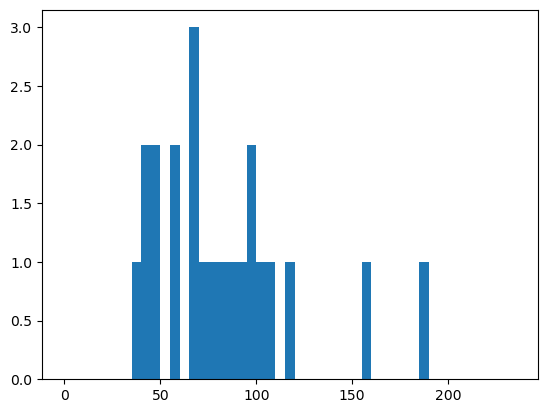

SRA coverage 37.84-236.2


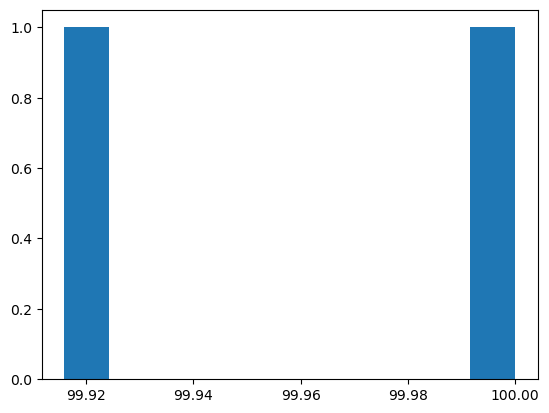

minimum SRA perc 99.916


{100.0: 'MHOM-SD-82-BIYAMINA-bis', 99.916: 'TRPZ26'}

In [17]:
#examine Tbr

tbr_markers=['SRAsouth (AJ345058.1)','SRAnorth (AJ345057.1)']

df=meta_0405.loc[metadf2[metadf2['taxon']=='T.b. rhodesiense'].index]
max_coverage={max([float(c) for c in df[[f'{marker} coverage' for marker in tbr_markers]].loc[tbr] if c != 'no_coverage_file']):tbr 
              for tbr in df.index}
plt.hist(max_coverage.keys(),bins=range(0,round(max(max_coverage)),5))
plt.show()
print(f"SRA coverage {min(max_coverage.keys())}-{max(max_coverage.keys())}")
max_coverage={max([float(c) if c != 'no hit' else 0 for c in df[[f'{marker} perc' for marker in tbr_markers]].loc[tbr]]):tbr 
              for tbr in df.index}
plt.hist(max_coverage.keys())
plt.show()
print(f"minimum SRA perc {min(max_coverage.keys())}")
max_coverage

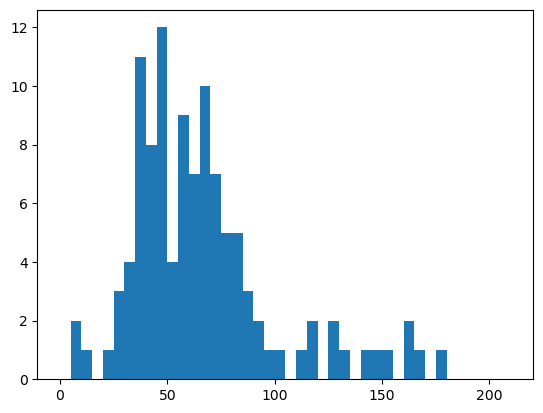

minimum TgsGP coverage 6.65-214.52


ValueError: could not convert string to float: 'no hit'

In [18]:
#examine TbgI
tbg_markers=['TgsGP_1 (AJ277951.1)','TgsGP_2 (FN555988.1)','TgsGP_Fre (FN555993.1)']
tbg_sup=['LiTat1.3_1 (AJ304413.1)','LiTat1.3_2 (KJ499460.1)', 'LiTat1.5_1 (EU257624.1)','LiTat1.5_2 (HQ662603.1)','VSG117 (S62479.1)']

df=meta_0405.loc[metadf2[metadf2['taxon']=='T.b. gambiense type I'].index]
max_coverage={max([float(c) for c in df[[f'{marker} coverage' for marker in tbg_markers]].loc[tbg] if c != 'no_coverage_file']):tbg 
              for tbg in df.index}
plt.hist(max_coverage.keys(),bins=range(0,round(max(max_coverage)),5))
plt.show()
print(f"minimum TgsGP coverage {min(max_coverage.keys())}-{max(max_coverage.keys())}")
max_coverage={min([float(c) for c in df[[f'{marker} perc' for marker in tbg_markers]].loc[tbg] if c != 'no_coverage_file']):tbg 
              for tbg in df.index}
plt.hist(max_coverage.keys())
plt.show()
print(f"minimum TgsGP perc {min(max_coverage.keys())}-{max(max_coverage.keys())}")

In [19]:
[k for k,v in tax_dct.items() if v =='T.b. gambiense type II']
[k for k,v in tax_dct.items() if v =='T.b. rhodesiense']
[k for k,v in tax_dct.items() if v =='T.b. brucei']
metadf2[metadf2['taxon']=='T.b. gambiense type I'][['country']].value_counts()
metadf2[metadf2['taxon']=='T.b. rhodesiense'][['host']].value_counts()
metadf2[metadf2['taxon']=='T.b. gambiense type II'][['continent','country']].value_counts()
metadf2[metadf2['taxon']=='T.b. brucei'][['continent','country']].value_counts()

continent        country                         
West Africa      Côte d'Ivoire                       43
                 Burkina Faso                         8
Southern Africa  Zambia                               6
na               na                                   6
East Africa      Uganda                               3
West Africa      Nigeria                              3
Central Africa   Democratic Republic of the Congo     2
                 Cameroon                             1
East Africa      Ethiopia                             1
                 Kenya                                1
                 Tanzania                             1
West Africa      Gambia                               1
                 The Gambia                           1
dtype: int64

In [20]:
metadf2['taxon']=newtaxon
#metadf2.to_csv('/home/jovyan/Minicircle_gRNA_families/In_files/all_annotated_metadata_isolates_20240410.csv')
metadf2.to_csv(f'/home/jovyan/Minicircle_gRNA_families/In_files/all_annotated_metadata_isolates_{date}.csv')

In [ ]:
metadf2[metadf2['taxon']=='T. brucei'][['host','Year of isolation', 'country', 'continent','TgsGP-qPCR', 'SRA-qPCR']]
#tax_dct
#metadf2.columns
len([i for i in tax_dct.values() if i == 'T.b. brucei'])
set(metadf2['taxon'])
len(metadf2[metadf2['taxon']=='T.b. brucei'])
#metadf2['taxon'].loc['MHOM-KE-82-LVH61R-bis']
len([i for i in tax_dct.values() if i == 'T.b. brucei'])